# Pneumonia detection

Sofia Kyba, Khrystyna Kokolus

**Importing libraries and data**

In [1]:
# import all needed libraries and packages
import os
import torch
import copy

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import torch.optim as optim
import torch.nn as nn

from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
from torchvision import transforms
from PIL import Image, ImageOps
from skimage import exposure
from tqdm import tqdm
import torch.nn.functional as F

Used data from https://www.kaggle.com/pcbreviglieri/pneumonia-xray-images

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
test_dir = '/content/drive/Shared drives/AI_PROJECT/data/test'
train_dir = '/content/drive/Shared drives/AI_PROJECT/data/train'
valid_dir = '/content/drive/Shared drives/AI_PROJECT/data/val'


In [4]:
class_names = os.listdir(train_dir)

In [5]:
# list has two lists inside, where the first one includes images with pneumonia and the second one includes normal images
test_image_files = [[os.path.join(test_dir, class_name, x) 
               for x in os.listdir(os.path.join(test_dir, class_name))] 
               for class_name in class_names]

train_image_files_first = [[os.path.join(train_dir, class_name, x) 
               for x in os.listdir(os.path.join(train_dir, class_name))] 
               for class_name in class_names]

train_with_pneumonia = train_image_files_first[0][:len(train_image_files_first[0]) // 2]
train_with_norm = train_image_files_first[1]
train_image_files = [train_with_pneumonia,  train_with_norm]

valid_image_files = [[os.path.join(valid_dir, class_name, x) 
               for x in os.listdir(os.path.join(valid_dir, class_name))] 
               for class_name in class_names]


In [6]:
print("Size of training set: ")
print(f"Number of images with pneumonia: {len(train_image_files_first[0])} and with normal lungs {len(train_image_files_first[1])}\n")

print("Size of test set: ")
print(f"Number of images with pneumonia: {len(test_image_files[0])} and with normal lungs {len(test_image_files[1])}\n")

print("Size of validation set: ")
print(f"Number of images with pneumonia: {len(valid_image_files[0])} and with normal lungs {len(valid_image_files[1])}")

Size of training set: 
Number of images with pneumonia: 3110 and with normal lungs 1082

Size of test set: 
Number of images with pneumonia: 390 and with normal lungs 234

Size of validation set: 
Number of images with pneumonia: 788 and with normal lungs 267


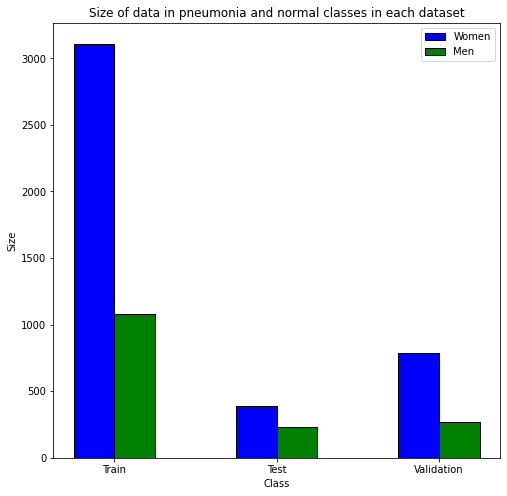

In [7]:
pn = [len(train_image_files_first[0]), len(test_image_files[0]), len(valid_image_files[0])]
norm = [len(train_image_files_first[1]), len(test_image_files[1]), len(valid_image_files[1])]
  
r = np.arange(3)
width = 0.25

fig = plt.figure(figsize = (8, 8))

plt.bar(r, pn, color = 'b',
        width = width, edgecolor = 'black',
        label='Women')
plt.bar(r + width, norm, color = 'g',
        width = width, edgecolor = 'black',
        label='Men')
  
plt.xlabel("Class")
plt.ylabel("Size")
plt.title("Size of data in pneumonia and normal classes in each dataset")
  
# plt.grid(linestyle='--')
plt.xticks(r + width/2, ['Train','Test','Validation'])
plt.legend()
  
plt.show()

In [8]:
# Finding weights to make data to balance the data
counter_pn = len(train_with_pneumonia)
counter_normal = len(train_with_norm)
all = len(train_with_pneumonia) + len(train_with_norm)

weight_pn = counter_pn/all
weight_normal = counter_normal/all
weights = torch.FloatTensor([weight_pn, weight_normal]).to("cpu")

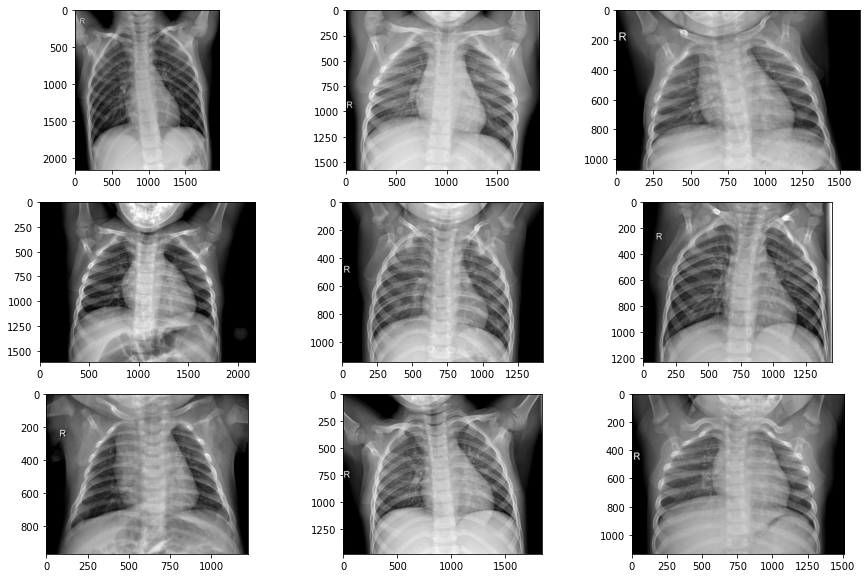

In [9]:
np.random.seed(40)
random_imgs_pn = []
random_imgs_normal = []
for i in range(9):
    random_imgs_pn.append(np.random.choice(train_with_pneumonia, replace = False))
    random_imgs_normal.append(np.random.choice(train_with_norm, replace = False))

# print random images with normal lungs

plt.figure(figsize=(15,10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(random_imgs_normal[i])
    plt.imshow(img,cmap='gray')


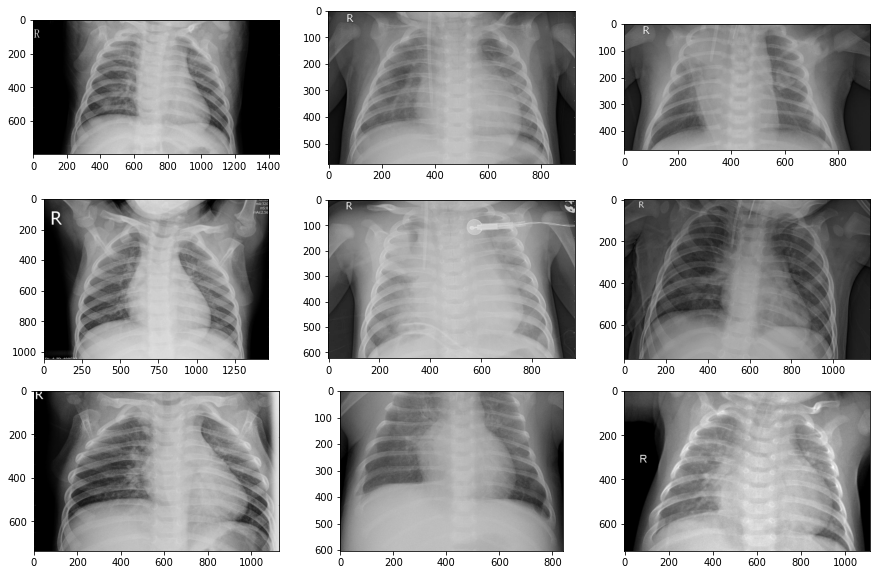

In [10]:
# print random images with pneumonia

plt.figure(figsize=(15,10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(random_imgs_pn[i])
    plt.imshow(img,cmap='gray')

# Image processing

In [11]:
# Make sure that the maximum pixel value is 255.0

pixels = plt.imread(test_image_files[0][0])

print(f"The maximum pixel value is {pixels.max():.1f} and the minimum is {pixels.min():.1f}")
print(f"The mean value of the pixels is {pixels.mean():.4f} and the standard deviation is {pixels.std():.4f}")

The maximum pixel value is 255.0 and the minimum is 0.0
The mean value of the pixels is 119.2892 and the standard deviation is 64.5236


In [12]:
# function for image processing for neural networks
def image_processing_nn(image):
    input_image = Image.open(image)
    input_image = input_image.convert("RGB")
    transformation = transforms.Compose([
        transforms.ToTensor()
    ])
    input_image = ImageOps.equalize(input_image)

    img_tr = transformation(input_image)
    mean, std = img_tr.mean([1,2]), img_tr.std([1,2])

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)
    return input_batch

In [13]:
# function for image processing for ml
def image_processing_ml(img_dataset):
    processed_images = []
    for i in range(len(img_dataset)):
        for image in img_dataset[i]:
          image_read = cv.imread(image)
          norm_img = np.zeros((800,800))
          img_normalized = cv.normalize(image_read,  norm_img, 0, 255, cv.NORM_MINMAX)
          resized = cv.resize(img_normalized, (50, 50)) #(512, 512)
          img_eq = exposure.equalize_hist(resized)
          processed_images.append(img_eq)
    return processed_images

In [14]:
image_classes_train = ["pneumonia"] * len(train_image_files[0]) + ["normal"] * len(train_image_files[1])
image_classes_test = ["pneumonia"] * len(test_image_files[0]) + ["normal"] * len(test_image_files[1])
image_classes_val = ["pneumonia"] * len(valid_image_files[0]) + ["normal"] * len(valid_image_files[1])

# Training with ML models

**Images preprocessing**

In [ ]:
processed_train_ml = image_processing_ml(train_image_files)

In [ ]:
processed_test_ml = image_processing_ml(test_image_files)

In [ ]:
processed_valid_ml = image_processing_ml(valid_image_files)

In [ ]:
def dimension_change(data_lst):
  arr = np.array(data_lst)
  nsamples, nx, ny, k = arr.shape
  d2_train_dataset = arr.reshape((nsamples, nx*ny, -1))

  nsamples, nx, ny = d2_train_dataset.shape
  d2_new = d2_train_dataset.reshape((nsamples,nx*ny))
  return d2_new

**Validation of Hyperparameters**

In [ ]:
from sklearn.metrics import accuracy_score
def validate_model(model, x, x_validate, y, y_validate):
  model.fit(x, y)
  y_pred = model.predict(x_validate)

  # accuracy metric for validation
  accuracy = accuracy_score(y_validate, y_pred)
  return model, accuracy

In [ ]:
import itertools
from copy import deepcopy 
def validation(model, x, x_validate, y, y_validate, possible_params):
    best_acc_score = np.Inf
    all_params = [dict(zip(possible_params.keys(), v)) for v in itertools.product(*possible_params.values())]

    for params in all_params:
        cur_model, cur_accuracy = validate_model(deepcopy(model(**params)), x, x_validate, y, y_validate)

        if cur_accuracy < best_acc_score:
            best_accuracy = cur_accuracy
            best_model = cur_model
            best_params = params

    
    print("\nBest hyper-parameters")
    for param_name in best_params:
        print(f"{param_name}: {best_params[param_name]}")

    print(f"\nBest accuracy: {best_accuracy}")
    
    return best_model

**SVM**

In [ ]:
# validation of hyperparameters of SVM ml algorithm

train_correct_dim_x = dimension_change(processed_train_ml)
val_correct_dim_x = dimension_change(processed_valid_ml)

svm = validation(svm.SVC,
                 train_correct_dim_x,
                 val_correct_dim_x,
                 image_classes_train,
                 image_classes_val,
                 possible_params = { "C": [0.01, 0.1, 1, 10],
                                    "kernel": ["linear",  "poly", "rbf"]})


Best hyper-parameters
C: 10
kernel: rbf

Best accuracy: 0.933649289099526


In [ ]:
svm_model = svm.SVC(C=10, kernel="rbf")

train_correct_dim_x = dimension_change(processed_train_ml)
test_correct_dim_x = dimension_change(processed_test_ml)

svm_model.fit(train_correct_dim_x, image_classes_train)
y_pred = svm_model.predict(test_correct_dim_x)
print("Prediction: ", y_pred)
print("Actual data: ", image_classes_test)

Prediction:  ['pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia'
 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia'
 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia'
 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia'
 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia'
 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'normal' 'pneumonia'
 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia'
 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia'
 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia'
 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia'
 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia'
 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia'
 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia'
 'pneumonia' 'pneumonia' 'pneumonia' 'pne

**Gboost**

In [ ]:
gradient_boost = validation(GradientBoostingClassifier,
                               train_correct_dim_x,
                                val_correct_dim_x,
                                image_classes_train,
                                image_classes_val,
                              possible_params={"loss": ["deviance", "exponential"],
                                               "learning_rate": [0.01, 0.1, 1],
                                                "n_estimators": [50, 100]})


Best hyper-parameters
loss: exponential
learning_rate: 1
n_estimators: 100

Best accuracy: 0.9052132701421801


In [ ]:
boost_model = GradientBoostingClassifier(loss="exponential", learning_rate=1, n_estimators=100)

train_correct_dim_x = dimension_change(processed_train_ml)
test_correct_dim_x = dimension_change(processed_test_ml)

boost_model.fit(train_correct_dim_x, image_classes_train)
y_pred = boost_model.predict(test_correct_dim_x)
print("Prediction: ", y_pred)
print("Actual data: ", image_classes_test)

Prediction:  ['pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia'
 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia'
 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia'
 'pneumonia' 'normal' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia'
 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia'
 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'normal' 'pneumonia'
 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia'
 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia'
 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia'
 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia'
 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia'
 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia'
 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia' 'pneumonia'
 'pneumonia' 'pneumonia' 'pneumonia' 'pneumo

# Training with NN models

**Data preprocessing**

In [15]:
processed_train_nn = []
for i in range(len(train_image_files)):
    for img in train_image_files[i]:
        processed_train_nn.append(image_processing_nn(img))

In [16]:
processed_test_nn = []
for i in range(len(test_image_files)):
    for img in test_image_files[i]:
        processed_test_nn.append(image_processing_nn(img))

In [17]:
processed_val_nn = []
for i in range(len(valid_image_files)):
    for img in valid_image_files[i]:
        processed_val_nn.append(image_processing_nn(img))

**Metric for evaluating model**

In [18]:
# metric
class AccuracyMetric:
    def __init__(self):
        self.correct, self.total = None, None
        self.reset()
        
    def update(self, y_pred, y_true):
        self.correct += torch.sum(y_pred.argmax(-1) == y_true).item()
        self.total += y_true.size(0)
        
    def compute(self):
        return self.correct / self.total
    
    def reset(self):
        self.correct = 0
        self.total = 0

**Training model**

In [19]:
# modified train
def train(model, train_loader, optimizer, criterion, device='cpu'):
    train_loss_history = []
    train_accuracy_history = []

    accuracy = AccuracyMetric()

    model.train()

    batch_train_loss = []
    
    for X_batch, y_batch in tqdm(train_loader):
        # perform single training step
        model.zero_grad()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
        accuracy.update(y_pred, y_batch)
        batch_train_loss.append(loss.item())
        
    mean_epoch_loss = np.mean(batch_train_loss)
    train_accuracy = accuracy.compute()
    
    train_loss_history.append(mean_epoch_loss)
    train_accuracy_history.append(train_accuracy)
    accuracy.reset()
    
    print(f'Train loss: {mean_epoch_loss:0.4f}, Accuracy: {train_accuracy: 0.4f}')
  

**Testing**

In [20]:
def test(model, val_loader):
    model.eval()
    
    total = 0
    correct = 0
    with torch.no_grad():
      for data, target in val_loader:
        output = model(data)
        correct += torch.sum(output.argmax(-1) == target).item()
        total += target.size(0)
    print("Test evaluation accuracy: {:.6f}".format(correct/total))

In [21]:
class_names = ["normal", "pneumonia"]
flat_lst_test = [item for sublist in test_image_files for item in sublist]
test_images_amount = len(flat_lst_test)

def find_predicted(model):
  predicted = []
  model.eval()  
  for i in range(0, test_images_amount):
      
      with torch.no_grad():
        output = model(processed_test_nn[i])

      _, index = torch.max(output, 1)
      predicted.append(class_names[index[0]])

  return predicted

**Getting data loaders for training and validation**

In [22]:
image_classes_train = [1] * len(train_image_files[0]) + [0] * len(train_image_files[1])
image_classes_val = [1] * len(valid_image_files[0]) + [0] * len(valid_image_files[1])

train_classes_torch = torch.from_numpy(np.array(image_classes_train))
processed_train_torch = torch.cat(processed_train_nn)
dataset_train = torch.utils.data.TensorDataset(processed_train_torch, train_classes_torch)

val_classes_torch = torch.from_numpy(np.array(image_classes_val))
processed_val_torch = torch.cat(processed_val_nn)
dataset_val = torch.utils.data.TensorDataset(processed_val_torch, val_classes_torch)

# loader of the training set
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=64, shuffle=True)

# loader of the validation set
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=64, shuffle=False)

data_loader = {"train": train_loader, "valid": val_loader}


**CNN**

In [ ]:
class CNN(torch.nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        
        self.convlayers = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, (5, 5)), 
            torch.nn.Tanh(),
            torch.nn.MaxPool2d((2, 2), stride=2),
            torch.nn.BatchNorm2d(64),
            
            torch.nn.Conv2d(64, 16, (5, 5)), 
            torch.nn.Tanh(),
            torch.nn.MaxPool2d((2, 2), stride=2),
            torch.nn.BatchNorm2d(16),
        )

        self.fc = torch.nn.Sequential(
            torch.nn.Linear(2304, 120),
            torch.nn.ReLU(inplace=True),

            torch.nn.Linear(120, 84),
            torch.nn.ReLU(inplace=True),

            torch.nn.Linear(84, num_classes),
        )

    def forward(self, x):
        x = self.convlayers(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [ ]:
# dataset exploration

x = processed_train_nn[0]
x.size()

torch.Size([3, 32, 32])

In [ ]:
cnn_model = CNN(num_classes=2)

In [ ]:
device = 'cpu'
BATCH_SIZE = 64
EPOCHS = 25
LR = 1e-4
weight = 1e-5

In [ ]:
cnn_model.to(device)

CNN(
  (convlayers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=2304, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=2, bias=True)
  )
)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss(weights)

In [ ]:
for epoch in range(1, 11):
      print('Epoch {}'.format(epoch))
      train(cnn_model, train_loader, optimizer, criterion)
      test(cnn_model, val_loader)

Epoch 1


100%|██████████| 42/42 [04:20<00:00,  6.21s/it]


Train loss: 0.0771, Accuracy:  0.9697
Test evaluation accuracy: 0.919431
Epoch 2


100%|██████████| 42/42 [04:25<00:00,  6.33s/it]


Train loss: 0.0715, Accuracy:  0.9750
Test evaluation accuracy: 0.908057
Epoch 3


100%|██████████| 42/42 [04:22<00:00,  6.26s/it]


Train loss: 0.0662, Accuracy:  0.9738
Test evaluation accuracy: 0.926066
Epoch 4


100%|██████████| 42/42 [04:26<00:00,  6.34s/it]


Train loss: 0.0532, Accuracy:  0.9791
Test evaluation accuracy: 0.923223
Epoch 5


100%|██████████| 42/42 [04:20<00:00,  6.21s/it]


Train loss: 0.0536, Accuracy:  0.9818
Test evaluation accuracy: 0.834123
Epoch 6


100%|██████████| 42/42 [04:22<00:00,  6.24s/it]


Train loss: 0.0587, Accuracy:  0.9780
Test evaluation accuracy: 0.923223
Epoch 7


100%|██████████| 42/42 [04:21<00:00,  6.23s/it]


Train loss: 0.0226, Accuracy:  0.9909
Test evaluation accuracy: 0.912796
Epoch 8


100%|██████████| 42/42 [04:24<00:00,  6.29s/it]


Train loss: 0.0166, Accuracy:  0.9985
Test evaluation accuracy: 0.904265
Epoch 9


100%|██████████| 42/42 [04:23<00:00,  6.27s/it]


Train loss: 0.0221, Accuracy:  0.9936
Test evaluation accuracy: 0.917536
Epoch 10


100%|██████████| 42/42 [04:21<00:00,  6.22s/it]


Train loss: 0.0123, Accuracy:  0.9992
Test evaluation accuracy: 0.919431


**Resnet**

In [ ]:
resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
for pars in resnet_model.parameters():
    pars.requires_grad = False

num_features = resnet_model.fc.in_features
num_classes = 2
resnet_model.fc = torch.nn.Sequential(
    torch.nn.Linear(num_features, num_classes)
)

# define a loss function and optimizer
res_optimizer = optim.SGD(resnet_model.fc.parameters(), lr=0.001, momentum=0.9)
res_criterion = nn.CrossEntropyLoss(weights)


Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
for epoch in range(1, 11):
      print('Epoch {}'.format(epoch))
      train(resnet_model, train_loader, res_optimizer, res_criterion)
      test(resnet_model, val_loader)

Epoch 1


100%|██████████| 42/42 [09:57<00:00, 14.22s/it]


Train loss: 0.1260, Accuracy:  0.9579
Test evaluation accuracy: 0.926066
Epoch 2


100%|██████████| 42/42 [09:54<00:00, 14.15s/it]


Train loss: 0.1268, Accuracy:  0.9549
Test evaluation accuracy: 0.921327
Epoch 3


100%|██████████| 42/42 [09:52<00:00, 14.12s/it]


Train loss: 0.1263, Accuracy:  0.9556
Test evaluation accuracy: 0.924171
Epoch 4


100%|██████████| 42/42 [09:53<00:00, 14.13s/it]


Train loss: 0.1236, Accuracy:  0.9549
Test evaluation accuracy: 0.920379
Epoch 5


100%|██████████| 42/42 [09:56<00:00, 14.19s/it]


Train loss: 0.1187, Accuracy:  0.9556
Test evaluation accuracy: 0.933649
Epoch 6


100%|██████████| 42/42 [09:53<00:00, 14.13s/it]


Train loss: 0.1217, Accuracy:  0.9553
Test evaluation accuracy: 0.921327
Epoch 7


100%|██████████| 42/42 [09:53<00:00, 14.13s/it]


Train loss: 0.1323, Accuracy:  0.9534
Test evaluation accuracy: 0.918483
Epoch 8


100%|██████████| 42/42 [09:56<00:00, 14.20s/it]


Train loss: 0.1349, Accuracy:  0.9534
Test evaluation accuracy: 0.919431
Epoch 9


100%|██████████| 42/42 [09:58<00:00, 14.25s/it]


Train loss: 0.1189, Accuracy:  0.9621
Test evaluation accuracy: 0.930806
Epoch 10


100%|██████████| 42/42 [10:00<00:00, 14.30s/it]


Train loss: 0.1257, Accuracy:  0.9556
Test evaluation accuracy: 0.933649


**MobileNet**

In [23]:
mobile_model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
for pars in mobile_model.parameters():
    pars.requires_grad = False

mobile_model.eval()

num_features = 1280
num_classes = 2
mobile_model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=False),
    torch.nn.Linear(num_features, num_classes)
)


mob_optimizer = optim.SGD(mobile_model.classifier.parameters(), lr=0.001, momentum=0.9)
mob_criterion = nn.CrossEntropyLoss(weights)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [24]:
for epoch in range(1, 11):
      print('Epoch {}'.format(epoch))
      train(mobile_model, train_loader, mob_optimizer, mob_criterion)
      test(mobile_model, val_loader)

Epoch 1


100%|██████████| 42/42 [03:06<00:00,  4.44s/it]


Train loss: 0.4469, Accuracy:  0.8161
Test evaluation accuracy: 0.898578
Epoch 2


100%|██████████| 42/42 [03:05<00:00,  4.41s/it]


Train loss: 0.2421, Accuracy:  0.9158
Test evaluation accuracy: 0.890047
Epoch 3


100%|██████████| 42/42 [03:05<00:00,  4.43s/it]


Train loss: 0.2035, Accuracy:  0.9321
Test evaluation accuracy: 0.883412
Epoch 4


100%|██████████| 42/42 [03:06<00:00,  4.44s/it]


Train loss: 0.1794, Accuracy:  0.9393
Test evaluation accuracy: 0.911848
Epoch 5


100%|██████████| 42/42 [03:04<00:00,  4.40s/it]


Train loss: 0.1934, Accuracy:  0.9321
Test evaluation accuracy: 0.911848
Epoch 6


100%|██████████| 42/42 [03:05<00:00,  4.42s/it]


Train loss: 0.1643, Accuracy:  0.9427
Test evaluation accuracy: 0.909953
Epoch 7


100%|██████████| 42/42 [03:04<00:00,  4.40s/it]


Train loss: 0.1703, Accuracy:  0.9382
Test evaluation accuracy: 0.900474
Epoch 8


100%|██████████| 42/42 [03:05<00:00,  4.41s/it]


Train loss: 0.1571, Accuracy:  0.9401
Test evaluation accuracy: 0.917536
Epoch 9


100%|██████████| 42/42 [03:07<00:00,  4.47s/it]


Train loss: 0.1464, Accuracy:  0.9443
Test evaluation accuracy: 0.896682
Epoch 10


100%|██████████| 42/42 [03:10<00:00,  4.54s/it]


Train loss: 0.1606, Accuracy:  0.9416
Test evaluation accuracy: 0.900474


# Evaluation

**Metrics**

In [25]:
def evaluate(real, predicted):
    counter = 0
    for i in range(len(predicted)):
      if predicted[i] == real[i]:
        counter += 1
    print("Amount of the coincidences: ", counter)
    print("Accuracy score: ", (counter / len(predicted)) * 100, "\n")

    conf_matrix = confusion_matrix(real, predicted)
    print("Confusion matrix: \n", conf_matrix, "\n")

    conf_accuracy = (conf_matrix[1][1] + conf_matrix[0][0]) / (conf_matrix[1][1] + conf_matrix[0][0] + conf_matrix[0][1] + conf_matrix[1][0])
    print("Accuracy using confusion matrix: ", conf_accuracy * 100, "\n")

    print("Classification report: \n", classification_report(real, predicted))

**SVM**

In [ ]:
evaluate(image_classes_test, y_pred)

Amount of the coincidences:  496
Accuracy score:  79.48717948717949 

Confusion matrix: 
 [[113 121]
 [  7 383]] 

Accuracy using confusion matrix:  79.48717948717949 

Classification report: 
               precision    recall  f1-score   support

      normal       0.94      0.48      0.64       234
   pneumonia       0.76      0.98      0.86       390

    accuracy                           0.79       624
   macro avg       0.85      0.73      0.75       624
weighted avg       0.83      0.79      0.77       624



**Gboost**

In [ ]:
evaluate(image_classes_test, y_pred)

Amount of the coincidences:  482
Accuracy score:  77.24358974358975 

Confusion matrix: 
 [[109 125]
 [ 17 373]] 

Accuracy using confusion matrix:  77.24358974358975 

Classification report: 
               precision    recall  f1-score   support

      normal       0.87      0.47      0.61       234
   pneumonia       0.75      0.96      0.84       390

    accuracy                           0.77       624
   macro avg       0.81      0.71      0.72       624
weighted avg       0.79      0.77      0.75       624



**CNN**

In [ ]:
predicted = find_predicted(cnn_model)

In [ ]:
evaluate(image_classes_test, predicted)

Amount of the coincidences:  492
Accuracy score:  78.84615384615384 

Confusion matrix: 
 [[113 121]
 [ 11 379]] 

Accuracy using confusion matrix:  78.84615384615384 

Classification report: 
               precision    recall  f1-score   support

      normal       0.91      0.48      0.63       234
   pneumonia       0.76      0.97      0.85       390

    accuracy                           0.79       624
   macro avg       0.83      0.73      0.74       624
weighted avg       0.82      0.79      0.77       624



**ResNet**

In [ ]:
predicted = find_predicted(resnet_model)

In [ ]:
evaluate(image_classes_test, predicted)

Amount of the coincidences:  513
Accuracy score:  82.21153846153845 

Confusion matrix: 
 [[138  96]
 [ 15 375]] 

Accuracy using confusion matrix:  82.21153846153845 

Classification report: 
               precision    recall  f1-score   support

      normal       0.90      0.59      0.71       234
   pneumonia       0.80      0.96      0.87       390

    accuracy                           0.82       624
   macro avg       0.85      0.78      0.79       624
weighted avg       0.84      0.82      0.81       624



**MobileNet**

In [26]:
predicted = find_predicted(mobile_model)

In [27]:
evaluate(image_classes_test, predicted)

Amount of the coincidences:  550
Accuracy score:  88.14102564102564 

Confusion matrix: 
 [[172  62]
 [ 12 378]] 

Accuracy using confusion matrix:  88.14102564102564 

Classification report: 
               precision    recall  f1-score   support

      normal       0.93      0.74      0.82       234
   pneumonia       0.86      0.97      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.85      0.87       624
weighted avg       0.89      0.88      0.88       624



# Best model

In [31]:
best_model = mobile_model
flat_lst_test = [item for sublist in test_image_files for item in sublist]
images_to_show = flat_lst_test[:10] + flat_lst_test[-10:] # first 10 with pneumonia and last 10 are normal

Image 0


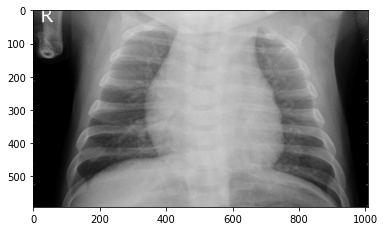

pneumonia 99.70640563964844
Image 1


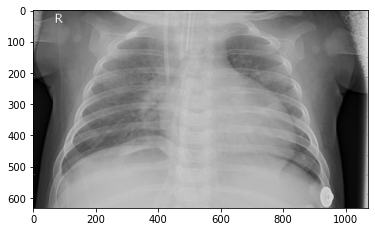

pneumonia 99.34915924072266
Image 2


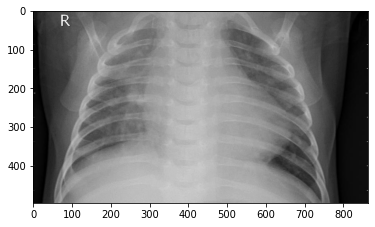

pneumonia 99.67035675048828
Image 3


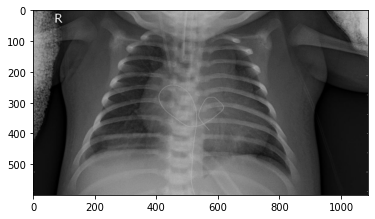

pneumonia 93.52313232421875
Image 4


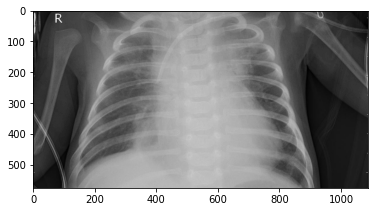

pneumonia 99.84030151367188
Image 5


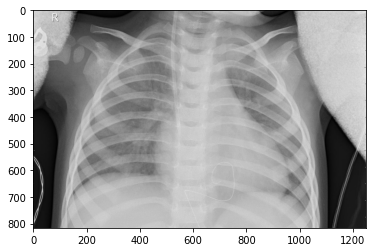

pneumonia 84.95232391357422
Image 6


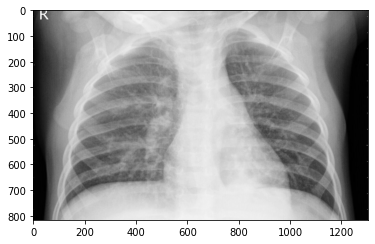

pneumonia 75.21036529541016
Image 7


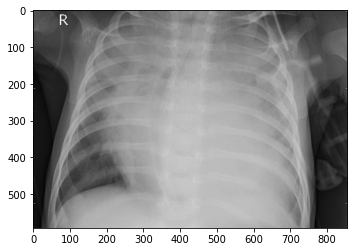

pneumonia 99.9610595703125
Image 8


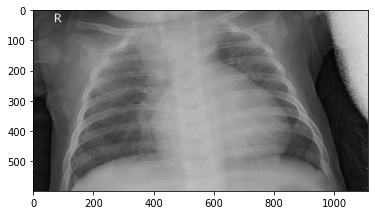

pneumonia 99.25503540039062
Image 9


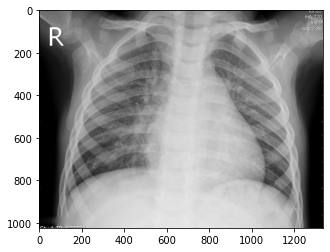

pneumonia 94.84770202636719
Image 10


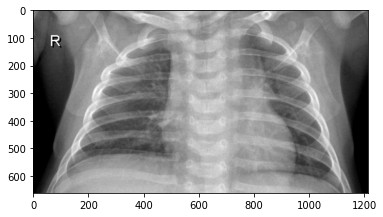

pneumonia 83.83163452148438
Image 11


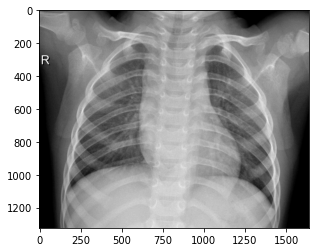

normal 99.43521881103516
Image 12


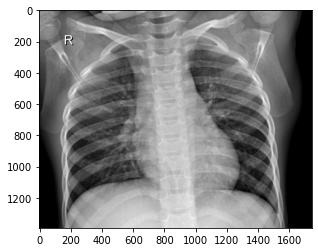

normal 95.63152313232422
Image 13


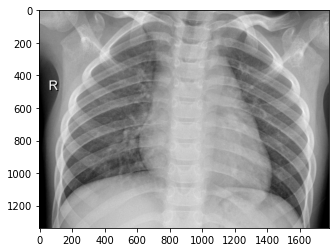

normal 86.8701400756836
Image 14


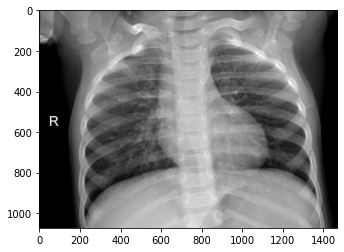

normal 81.27790832519531
Image 15


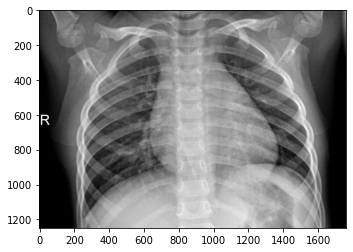

normal 99.65176391601562
Image 16


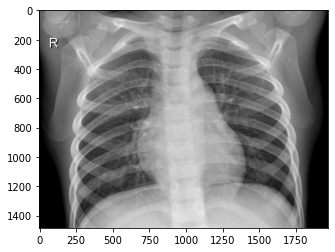

normal 90.00749969482422
Image 17


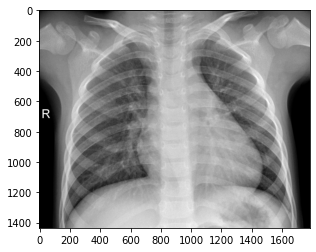

normal 97.92462158203125
Image 18


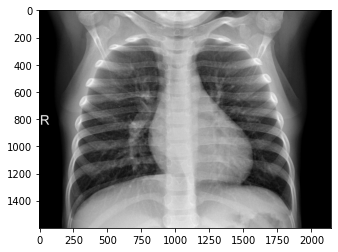

normal 72.22929382324219
Image 19


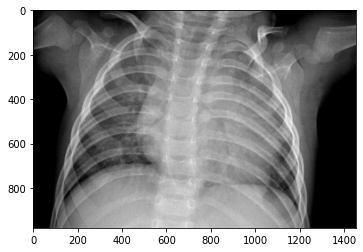

pneumonia 76.5272216796875


In [32]:
best_model.eval()   # put network in evaluation mode
for i in range(0, len(images_to_show)):
    print('Image '+str(i))
    img = Image.open(images_to_show[i])
    plt.imshow(img,cmap='gray')
    plt.show()
    plt.pause(0.1)
    # transform image and feed to the network 
    
    with torch.no_grad():
      transformed = image_processing_nn(images_to_show[i])
      output = best_model(transformed)
    
    # print the predicted class and corresponding probability
    
    _, index = torch.max(output, 1)
    prob = F.softmax(output, dim=1)[0] * 100.0
    print(class_names[index[0]], prob[index[0]].item())